In [1]:
using Plots,LinearAlgebra,Interpolations, Random, Distributions, Roots, NLopt, ForwardDiff, LaTeXStrings, DifferentialEquations
gr() #Load in packages
a=zeros(2); α1=log(1); α2=log(1); #Parameter estimates
x=LinRange(0,20,21);
xx=LinRange(0,20,201);
σ=1/2;

In [2]:
function model(x,a) #Solve BVP
y = Vector{eltype(a)}(undef, length(x))
α1 = exp(a[1]); α2 = exp(a[2])
c(x) = α1*exp(-x*α2)
    for i in 1:length(x) 
    y[i] = c(x[i])
    end 
return y
end;

In [3]:
data=zeros(length(x));
data=[ 3.898952675812746  
2.569825438525737  
1.206631819080483  
1.3543817108830818 
0.6175527058221386 
0.30785528929186456
0.13649714414672498
0.6921031114954066 
0.271392505145547  
0.0945662375934022 
0.06039757137011752
0.1338145218277993 
0.1529291485263356
0.05189445084962129
0.02756210195622014
0.018066943988933968
0.017710583152626524
0.009164129234587067
0.008075081582671598
0.010557776318846062
0.004853780605374777]; #Data

In [4]:
function loglhood(data,a,σ) #Evaluate the log-normal loglikelihood
y=zeros(length(x))
y=model(x,a) # simulate deterministic model with parameters a
ℓ=0;
data_dists=[LogNormal(0,σ) for mi in y]; # LogNormal distribution
ℓ+=sum([loglikelihood(data_dists[i],data[i]./y[i]) for i in 1:length(data_dists)])  
return ℓ
end;

In [5]:
function funmle(a) #Evaluate the log-normal loglikelihood
return loglhood(data,a,σ)
end;

In [6]:
function Optimise(fun,θ₀,lb,ub)     #Numerical optimization with NLopt and Nelder-Mead
    tomax=(θ,∂θ)->fun(θ)
    opt=Opt(:LN_NELDERMEAD,length(θ₀))
    opt.max_objective=tomax
    opt.lower_bounds=lb      
    opt.upper_bounds=ub
    opt.maxtime=1*60
    res = optimize(opt,θ₀)
    return res[[2,1]]
end;

  0.945357 seconds (1.76 M allocations: 95.627 MiB, 33.39% gc time, 99.03% compilation time)


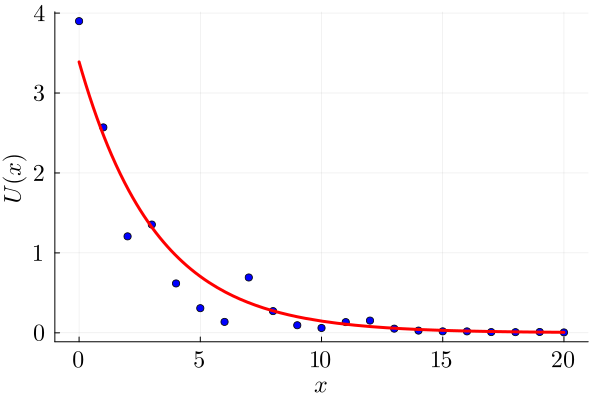

In [7]:
θG=[α1,α2] #Parameter estimates
lb=[-Inf,-Inf]; ub=[Inf,Inf] #Bounds
@time (xopt,fopt)=Optimise(funmle,θG,lb,ub) #Compute optimization
α1mle=exp(xopt[1])
α2mle=exp(xopt[2])
fmle=fopt
cmle(x) = α1mle*exp(-x*α2mle)
p1=scatter(x,data,mc=:blue,msc=:match,label=false)
p1=plot!(cmle,xx[1],xx[end],color=:red,label=false,xlabel=L"x",ylabel=L"U(x)",xlims=(xx[1]-1,xx[end]+1),lw=3)
p1=plot!(xticks = ([0,5,10,15,20],  [L"0", L"5", L"10", L"15", L"20"]))
p1=plot!(yticks = ([0,1,2,3,4], [L"0", L"1", L"2", L"3", L"4"]))
p1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16,ytickfontsize=16)
display(p1)

In [8]:
exp.(xopt)

2-element Vector{Float64}:
 3.3891095896659644
 0.3140559499494099

In [9]:
ff(θ1,θ2) = funmle([θ1,θ2]) #Compute the observed Fisher Information at the MLE
H = -ForwardDiff.hessian(z -> ff(z[1],z[2]),xopt)

2×2 Matrix{Float64}:
   84.0    -263.807
 -263.807  1132.29

In [10]:
rank(H) #Compute the rank of the observed Fisher Information

2

In [11]:
(evals,evecs)=eigen(H) #Compute the eigenvectors and eigenvalues of the observed Fisher Information

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
   21.355091999528433
 1194.9303915144521
vectors:
2×2 Matrix{Float64}:
 -0.972944  -0.23104
 -0.23104    0.972944

In [12]:
function ellipse(α1,α2,HH,xopt) #Function to compute the ellipse associated with the Wald interval
return -0.5*H[1,1]*(α1-xopt[1])^2-0.5*H[2,2]*(α2-xopt[2])^2-H[1,2]*(α1-xopt[1])*(α2-xopt[2]);
end

ellipse (generic function with 1 method)

In [13]:
N=50 #Set up grids and bounds for the univariate profile likelihood function computation
α1min=log(1); α1max=log(8);
α2min=log(0.2); α2max=log(0.4);
αα1=LinRange(α1min,α1max,N);
αα2=LinRange(α2min,α2max,N);

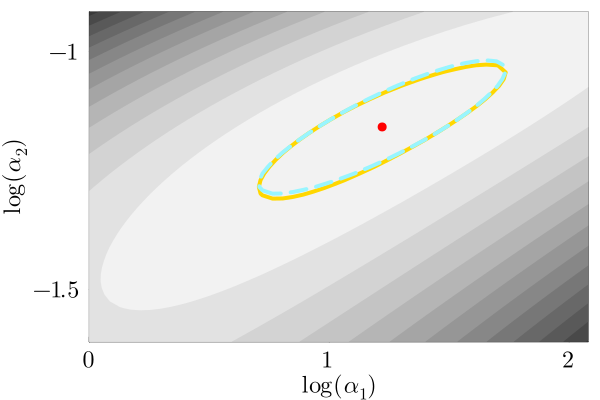

In [14]:
df=2 #Visualise the loglikelihood function, associated thresholds and MLE
llstar=-quantile(Chisq(df),0.95)/2
b1=contourf(αα1,αα2,(αα1,αα2)->funmle([αα1,αα2])-fopt,lw=0,xlabel=L"\log(α_1)",ylabel=L"\log(α_2)",c=:grays,colorbar=:false)
b1=scatter!([log(α1mle)],[log(α2mle)],markersize=3,markershape=:circle,markercolor=:red,msw=0,ms=5,label=false)
b1=contour!(αα1,αα2,(αα1,αα2)->funmle([αα1,αα2])-fopt,levels=[llstar],lw=4,c=:gold,legend=false)
b1=contour!(αα1,αα2,(αα1,αα2)->ellipse(αα1,αα2,H,xopt),levels=[llstar],lw=4,ls=:dash,c=:cadetblue1,legend=false)
b1=plot!(xlims=(α1min,α1max),xticks=([0, 1,2],[L"0",L"1",L"2"]))
b1=plot!(ylims=(α2min,α2max),yticks=([-1.5, -1],[L"-1.5",L"-1"]))
b1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)
display(b1)

In [15]:
#Univariate Profiles
df=1
llstar=-quantile(Chisq(df),0.95)/2;

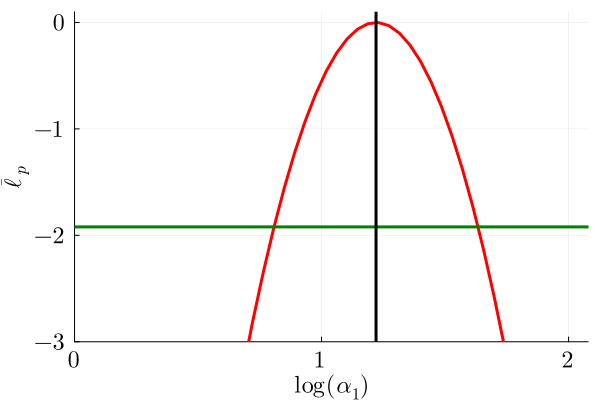

In [16]:
#Function to define univariate profile for α1  
function Uα1(α1)
a=zeros(1)    
function funα1(a)
return loglhood(data,[α1,a[1]],σ) 
end
θG=[log(α2mle)]
lb=[-Inf]
ub=[Inf]
(xopt,fopt)=Optimise(funα1,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fα1(x) = Uα1(x)[1]

q1=plot(fα1,αα1,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q1=hline!([llstar],legend=false,lw=3,lc=:green)
q1=vline!([log(α1mle)],lc=:black,legend=false,xlabel=L"\log(α_1)",ylabel=L"\bar{\ell}_p",lw=3)
q1=plot!(xlims=(minimum(αα1),maximum(αα1)),xticks=([0, 1,2],[L"0",L"1",L"2"]))
q1=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

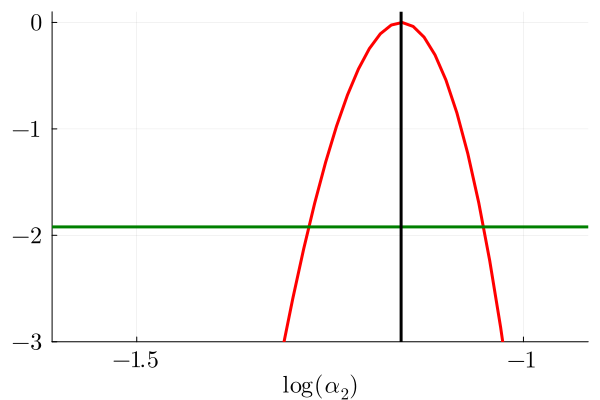

In [17]:
#Function to define univariate profile for α2 
function Uα2(α2)
a=zeros(1)    
function funα2(a)
return loglhood(data,[a[1],α2],σ) 
end
θG=[log(α1mle)]
lb=[-Inf]
ub=[Inf]
(xopt,fopt)=Optimise(funα2,θG,lb,ub)
llb=fopt-fmle
return llb,xopt
end 
fα2(x) = Uα2(x)[1]

q2=plot(fα2,αα2,ylims=(-3,0.1),legend=false,lc=:red,lw=3)
q2=hline!([llstar],legend=false,lw=3,lc=:green)
q2=vline!([log(α2mle)],lc=:black,legend=false,xlabel=L"\log(α_2)",lw=3)
q2=plot!(xlims=(minimum(αα2),maximum(αα2)),xticks=([-1.5, -1],[L"-1.5",L"-1"]))
q2=plot!(ylims=(-3,0.1),yticks=([-3,-2,-1,0],[L"-3", L"-2", L"-1",L"0"]))
q2=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)

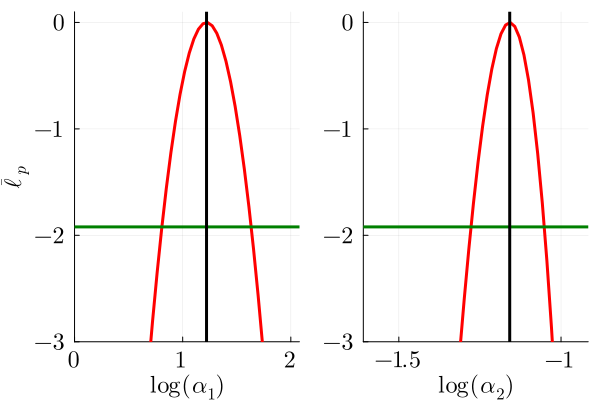

In [18]:
q3=plot(q1,q2,layout=(1,2))
display(q3)

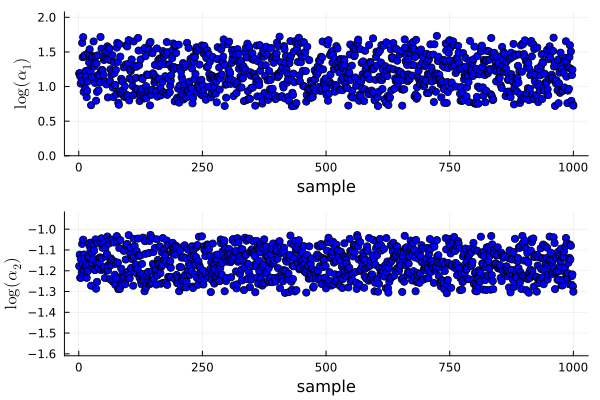

In [19]:
df=2 #Generate M parameter samples within the 95% confidence region by rejection sampling
llstar=-quantile(Chisq(df),0.95)/2

M=1000
α1sample=zeros(M)
α2sample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
logα1g=rand(Uniform(α1min,α1max))
logα2g=rand(Uniform(α2min,α2max))
    if (loglhood(data,[logα1g,logα2g],σ)-fmle) >= llstar 
    global kount+=1
    #println(kount)
    lls[kount]=loglhood(data,[logα1g,logα2g],σ)-fmle
    α1sample[kount]=logα1g;
    α2sample[kount]=logα2g;
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (α_1)",ylims=(α1min,α1max))
a2=scatter(α2sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log (α_2)",ylims=(α2min,α2max))
a3=plot(a1,a2,layout=(2,1))

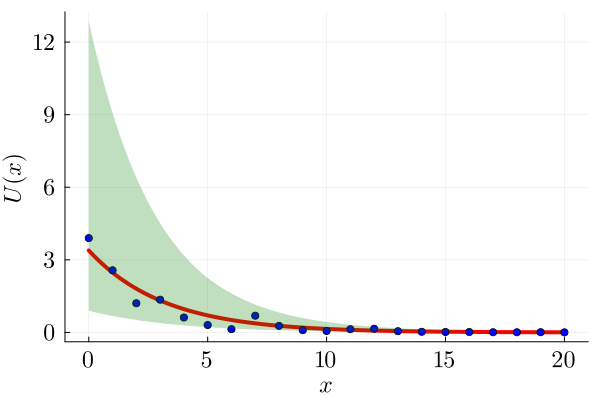

In [20]:
lower=100*ones(length(xx)) #For each parameter sample within the 95% confidence set, solve the model on a fine discretisation
upper=-100*ones(length(xx))


for i in 1:M
    c(x) = exp(α1sample[i])*exp(-x*exp(α2sample[i])) 
     
        for j in 1:length(xx)
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1]) < lower[j] 
                lower[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1]) #Compute the lower bound of the prediction interval by computing the 0.05 quantile of the noise model 
            end
           
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2]) > upper[j] 
                upper[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2]) #Compute the upper bound of the prediction interval by computing the 0.95 quantile of the noise model
            end
           
        end
    
    end
    


p1=plot(cmle,xx[1],xx[end],label=false,lc=:red,xlabel=L"x",ylabel=L"U(x)",xlims=(xx[1]-1,xx[end]+1),lw=4)
p1=plot!(xticks = ([0,5,10,15,20],  [L"0", L"5", L"10", L"15", L"20"]))
p1=plot!(yticks = ([0,3,6,9,12], [L"0", L"3", L"6", L"9", L"12"]))
p1=scatter!(x,data,mc=:blue,msc=:match,label=false)
p1=plot!(xguidefontsize=16, yguidefontsize=16,xtickfontsize=16, ytickfontsize=16)
p1=plot!(xx,lower,lw=0,fillrange=upper,fillalpha=0.25,color=:green,label=false,xlims=(-1,xx[end]+1))
display(p1)

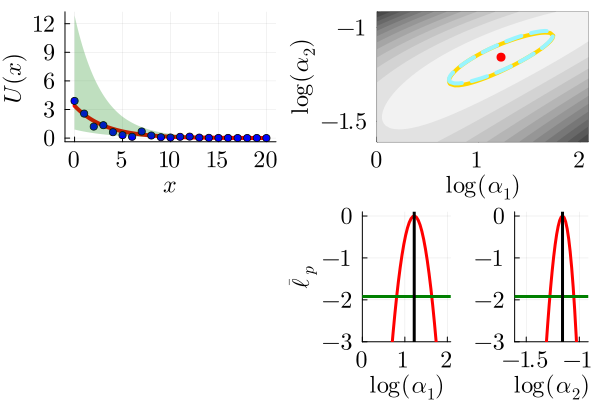

In [23]:
p9 = plot(legend=false,grid=false,foreground_color_subplot=:white)
s1=plot(p1,b1,p9,q3,layout=(2,2))
savefig(s1,"Figure4a.pdf")
display(s1)

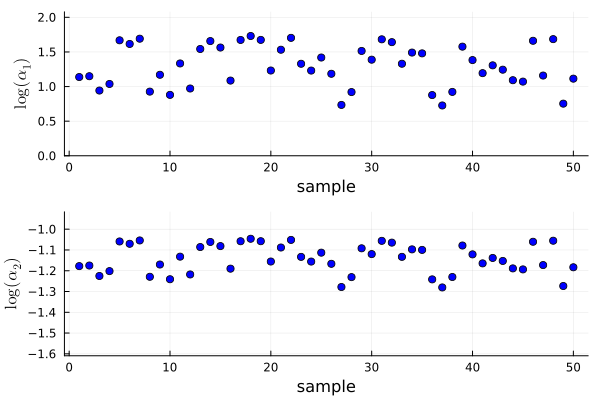

In [24]:
df=2
llstar=-quantile(Chisq(df),0.95)/2

M=50
α1sample=zeros(M)
α2sample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
logα1g=rand(Uniform(α1min,α1max))
logα2g=Uα1(logα1g)[2][1]
    if (loglhood(data,[logα1g,logα2g],σ)-fmle) >= llstar 
    global kount+=1
    lls[kount]=Uα1(logα1g)[1]
    α1sample[kount]=logα1g;
    α2sample[kount]=logα2g;    
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log(α_1)",ylims=(α1min,α1max))
a2=scatter(α2sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log(α_2)",ylims=(α2min,α2max))
a3=plot(a1,a2,layout=(2,1))

In [25]:
U1lower=100*ones(length(xx))
U1upper=-100*ones(length(xx))



for i in 1:M
    c(x) = exp(α1sample[i])*exp(-x*exp(α2sample[i])) 
     
        for j in 1:length(xx)
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1]) < U1lower[j] 
                U1lower[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1])
            end
           
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2]) > U1upper[j] 
                U1upper[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2])
            end
           
        end
    
    end

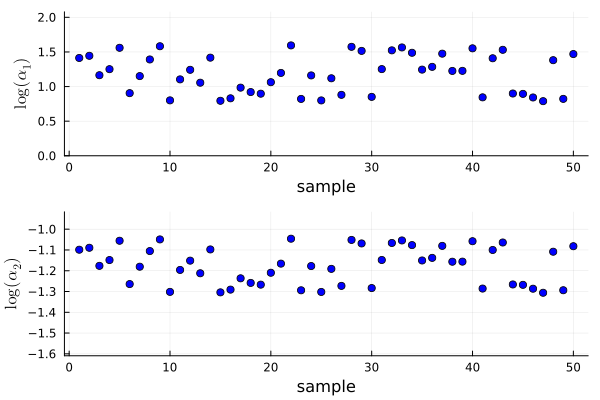

In [26]:
df=2
llstar=-quantile(Chisq(df),0.95)/2

M=50
α1sample=zeros(M)
α2sample=zeros(M)
lls=zeros(M)
global kount = 0
while kount < M
logα2g=rand(Uniform(α2min,α2max))
logα1g=Uα2(logα2g)[2][1]
    if (loglhood(data,[logα1g,logα2g],σ)-fmle) >= llstar 
    global kount+=1
    lls[kount]=Uα2(logα2g)[1]
    α2sample[kount]=logα2g;
    α1sample[kount]=logα1g;    
    end
end

a1=scatter(α1sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log(α_1)",ylims=(α1min,α1max))
a2=scatter(α2sample,mc=:blue,msc=:match,legend=false,xlabel="sample",ylabel=L"\log(α_2)",ylims=(α2min,α2max))
a3=plot(a1,a2,layout=(2,1))

In [27]:
U2lower=100*ones(length(xx))
U2upper=-100*ones(length(xx))



for i in 1:M
    c(x) = exp(α1sample[i])*exp(-x*exp(α2sample[i])) 
     
        for j in 1:length(xx)
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1]) < U2lower[j] 
                U2lower[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[1])
            end
           
            if c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2]) > U2upper[j] 
                U2upper[j] = c(xx[j])*exp(quantile(Normal(0,σ),[0.05,0.95])[2])
            end
           
        end
    
    end

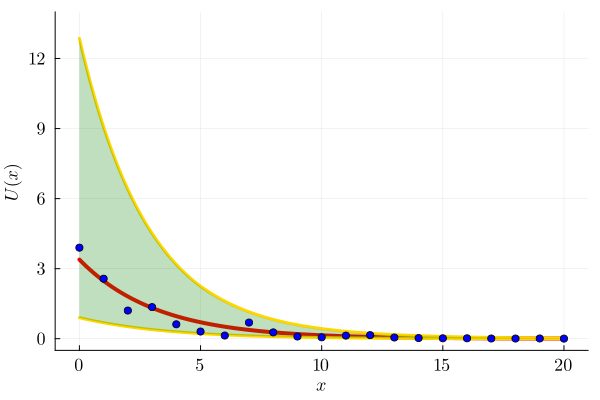

In [28]:
Ulower=100*ones(length(xx));
Uupper=-100*ones(length(xx));

for j in 1:length(xx)
Ulower[j] = min(U1lower[j],U2lower[j])
Uupper[j] = max(U1upper[j],U2upper[j])            
end


p1=plot(cmle,xx[1],xx[end],label=false,lc=:red,xlabel=L"x",ylabel=L"U(x)",xlims=(xx[1]-1,xx[end]+1),lw=4)
p1=plot!(xticks = ([0,5,10,15,20],  [L"0", L"5", L"10", L"15", L"20"]))
p1=plot!(ylims=(-0.5,14),yticks = ([0,3,6,9,12], [L"0", L"3", L"6", L"9", L"12"]))
p1=plot!(xguidefontsize=12, yguidefontsize=12,xtickfontsize=12, ytickfontsize=12)
q1=plot!(xx,lower,lc=:gold,lw=3,label=false)
q1=plot!(xx,upper,lc=:gold,lw=3,label=false)
p1=plot!(xx,Ulower,lw=0,fillrange=Uupper,fillalpha=0.25,color=:green,label=false,xlims=(-1,xx[end]+1))
p1=scatter!(x,data,mc=:blue,msc=:match,label=false)
display(p1)